In [1]:
%%capture
!apt-get install cmake
!apt-get install zlib1g-dev
!pip install gym[atari]
!pip install JSAnimation

In [1]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import gym

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.optimizers import rmsprop
import keras.backend as K


%matplotlib inline

/Users/sachin/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
env = gym.make("Pong-v0")

In [3]:
env.env.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [4]:
action_space = [0,2,3] #[No-op, up, down]

In [5]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))


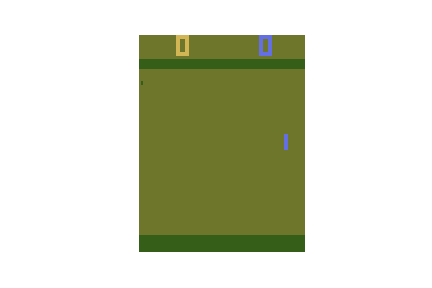
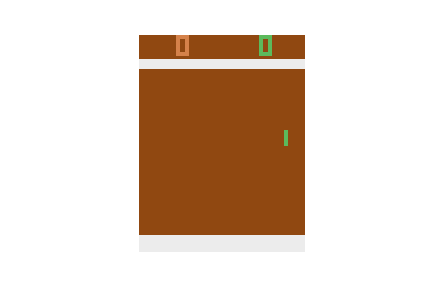
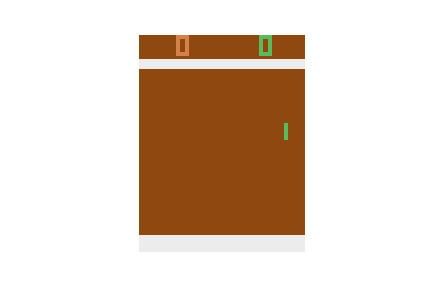
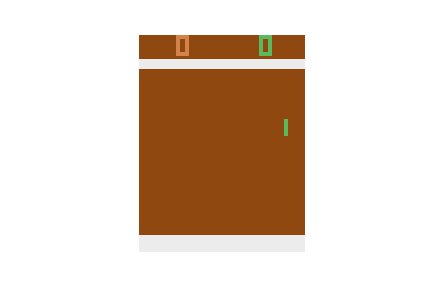
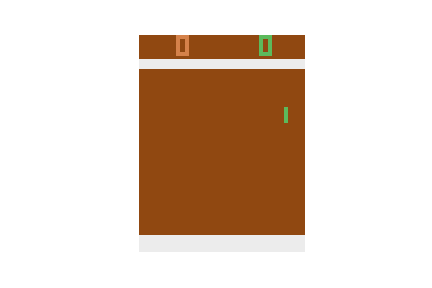
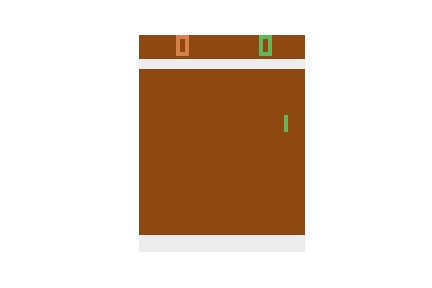
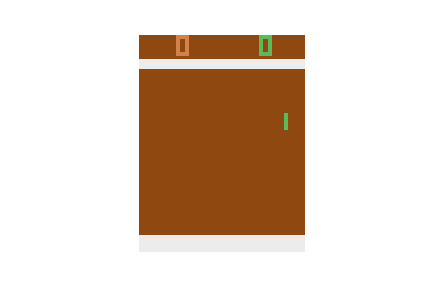
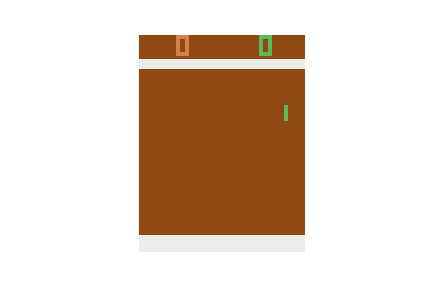
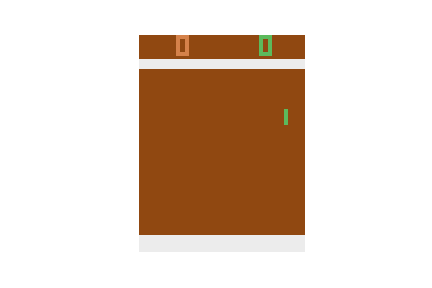
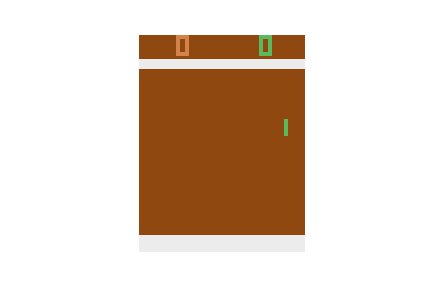
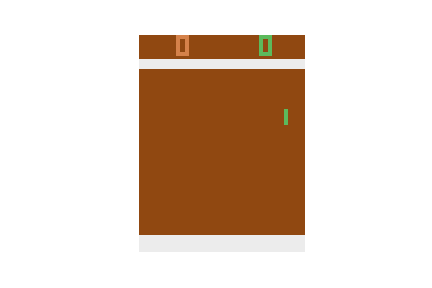
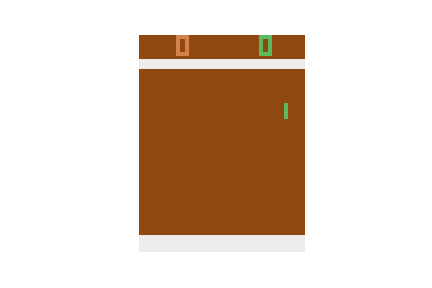
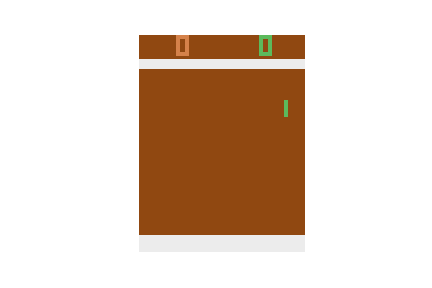
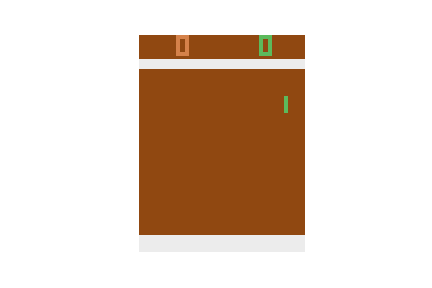
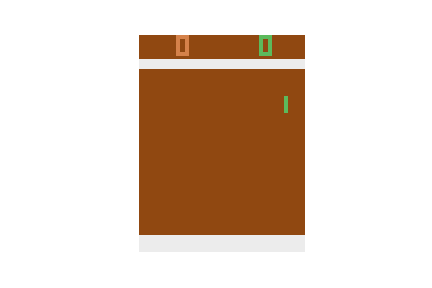
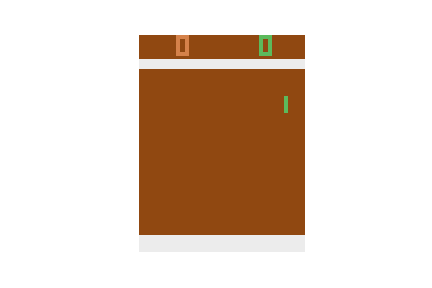
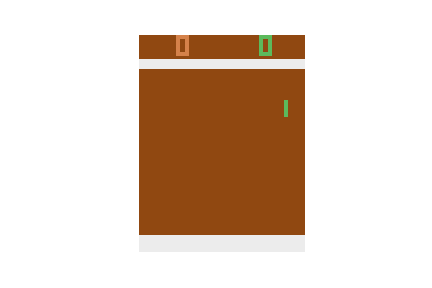
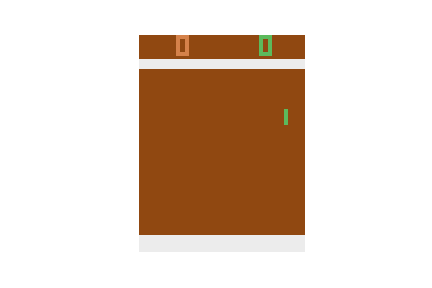
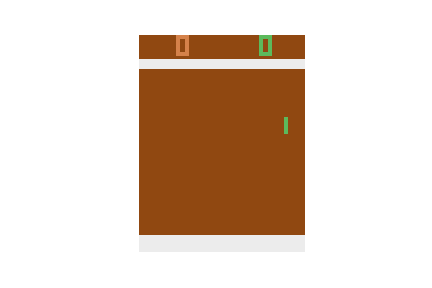
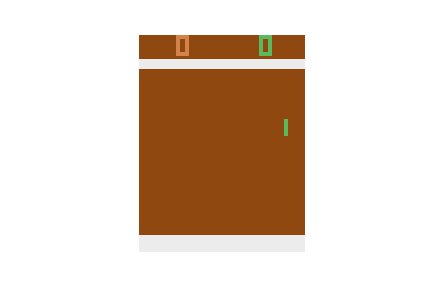
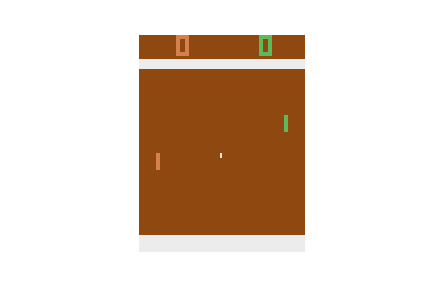
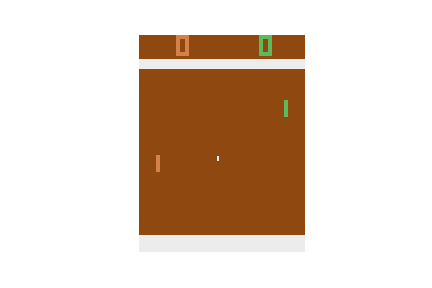
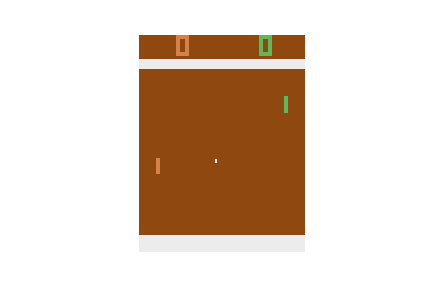
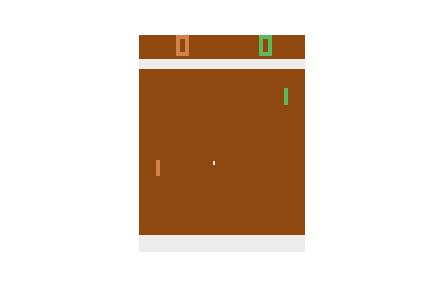
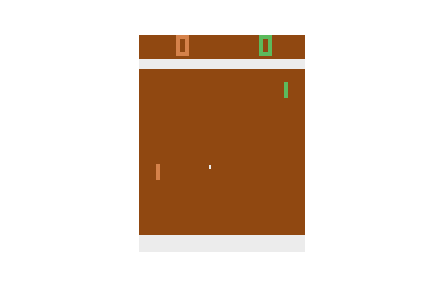
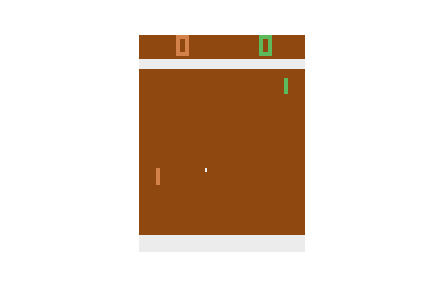
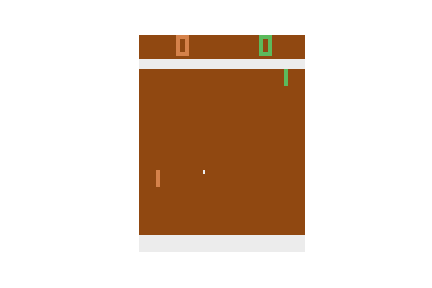
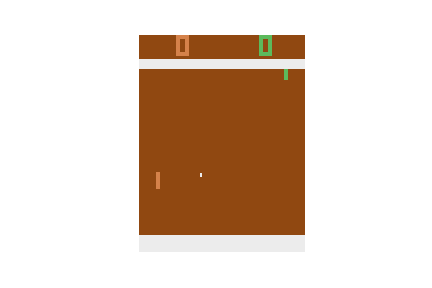
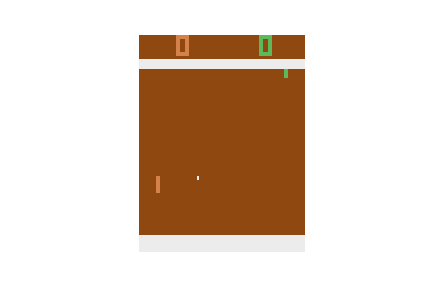
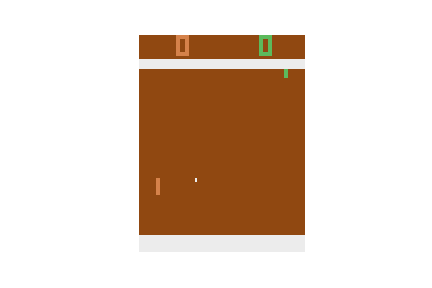
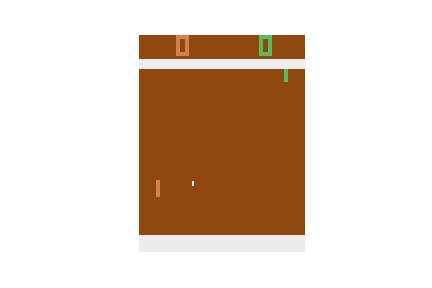
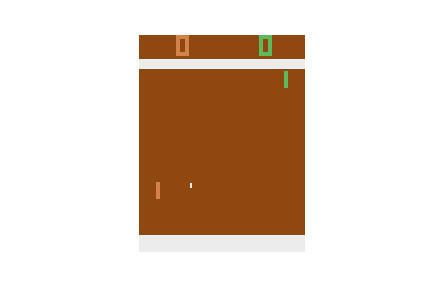
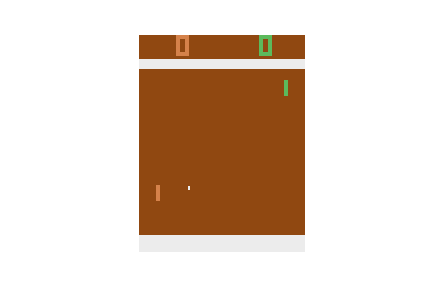
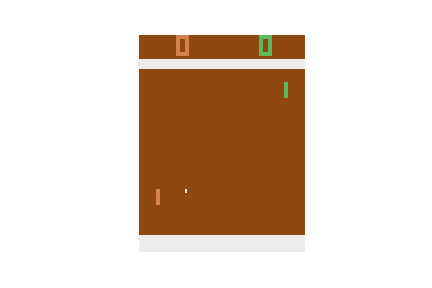
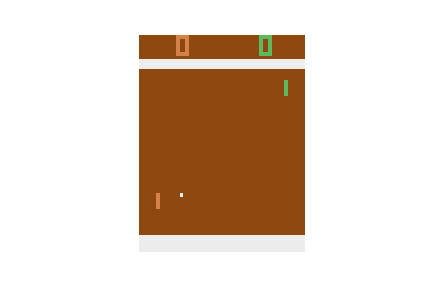
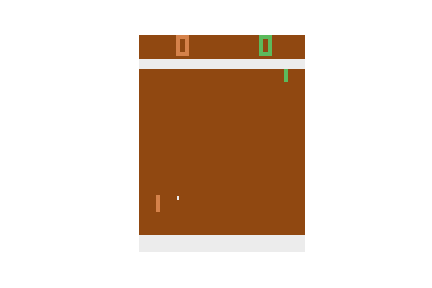
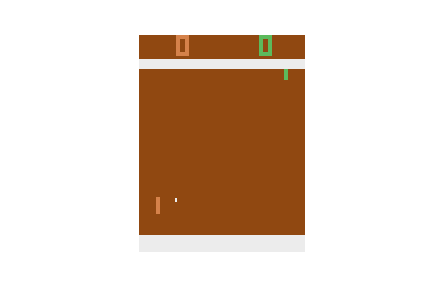
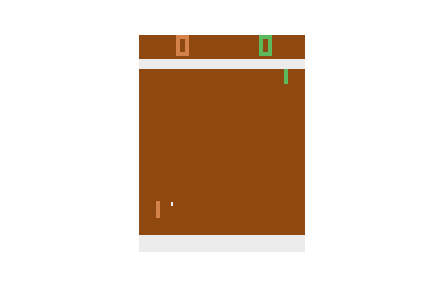
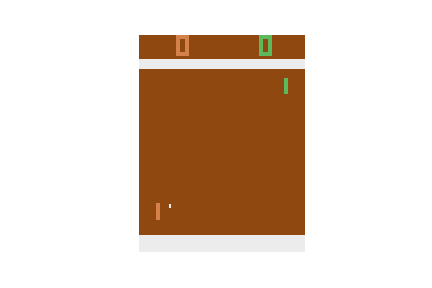
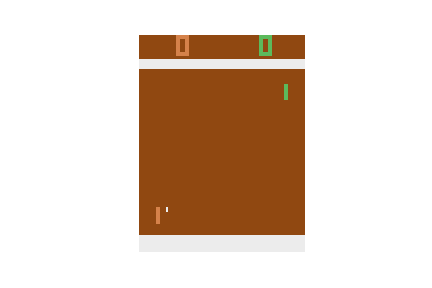
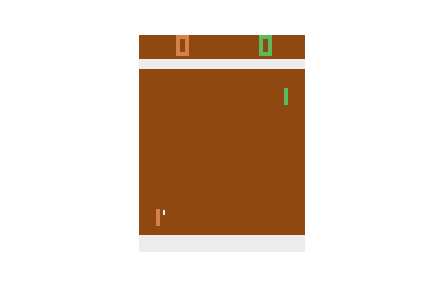
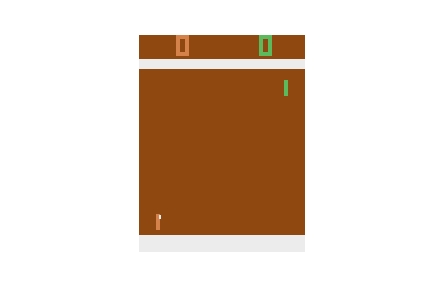
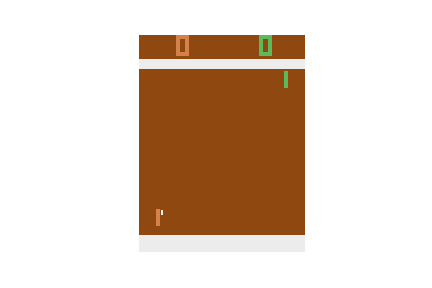
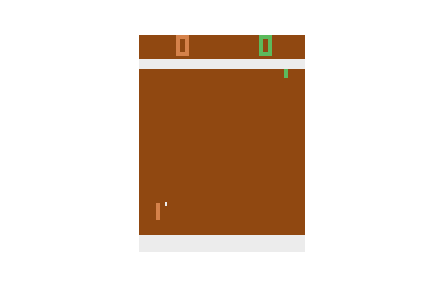
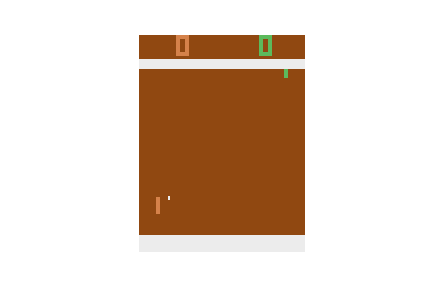
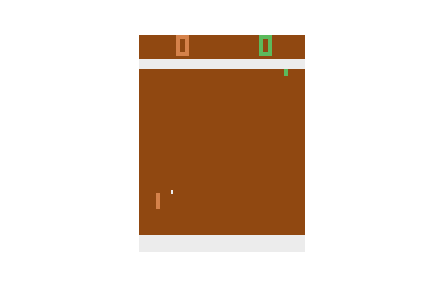
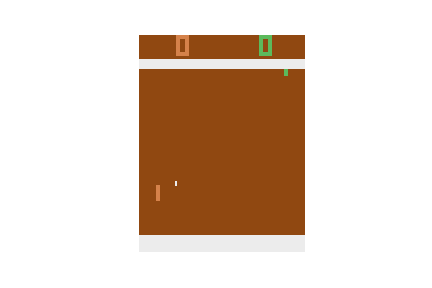
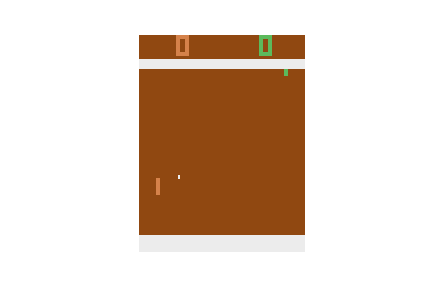
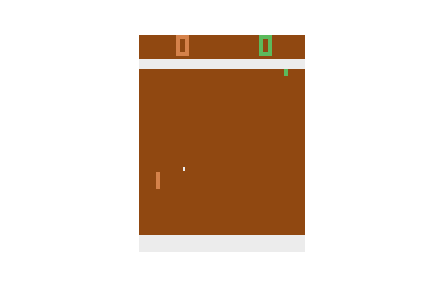
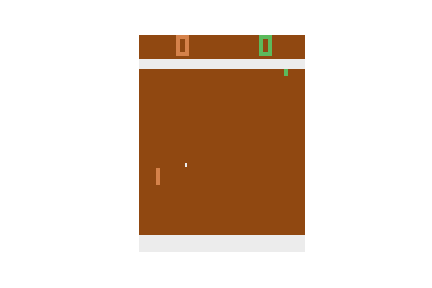
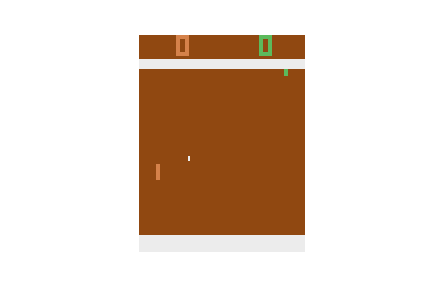
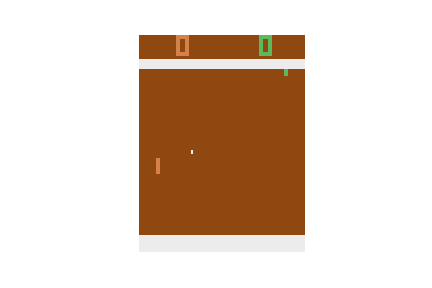
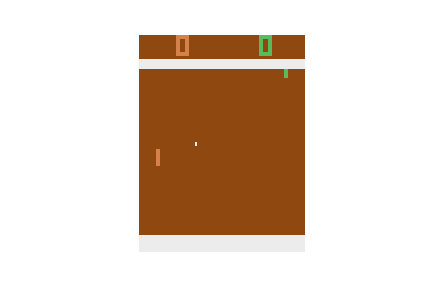
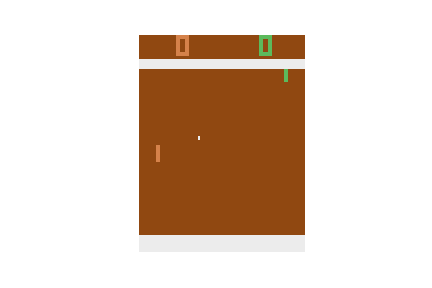
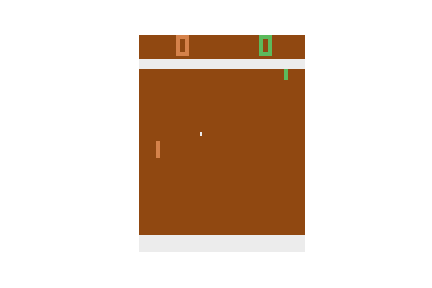
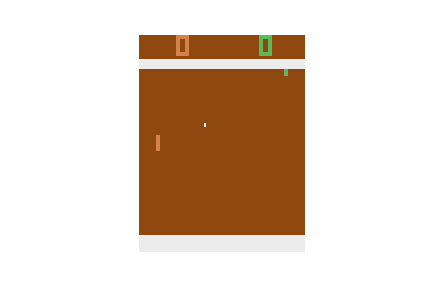
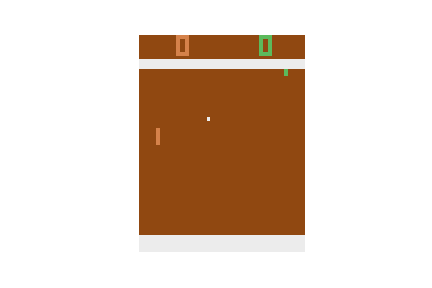
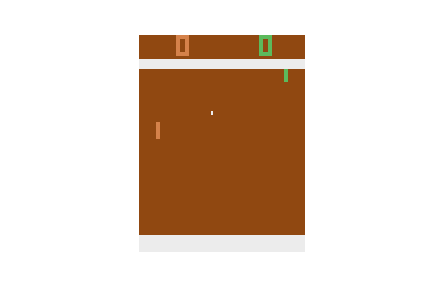
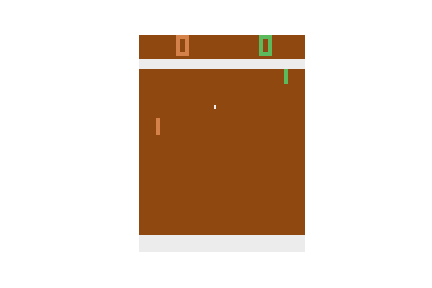
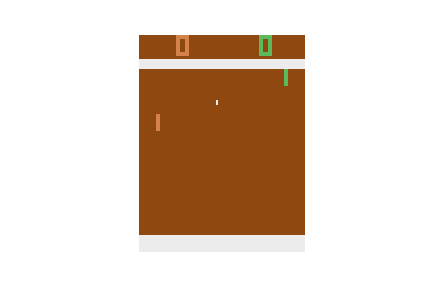
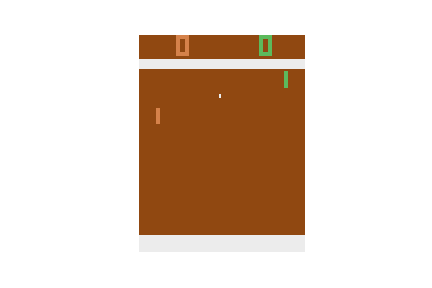
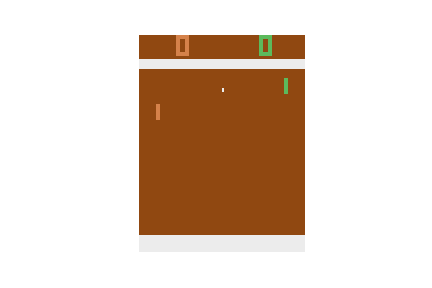
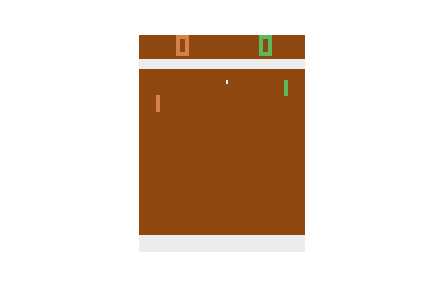
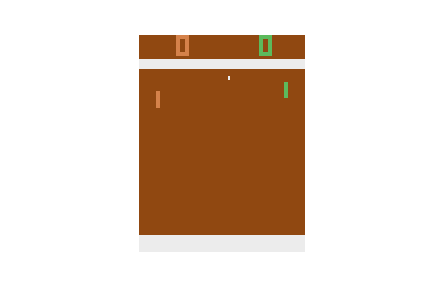
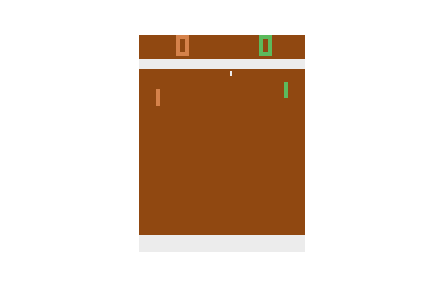
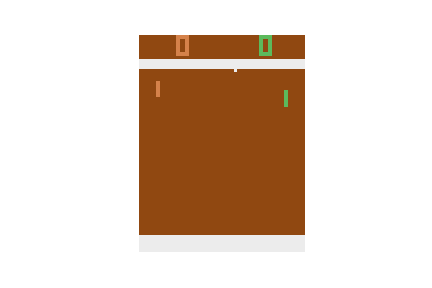
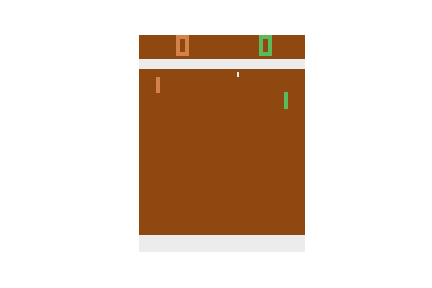
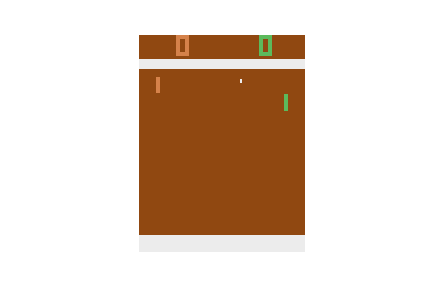
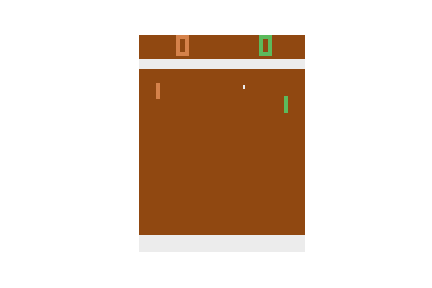
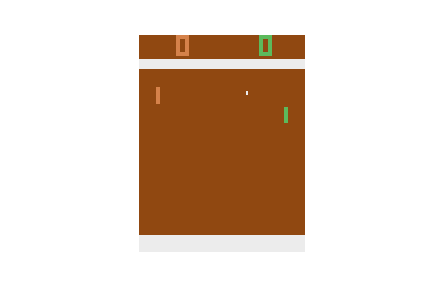
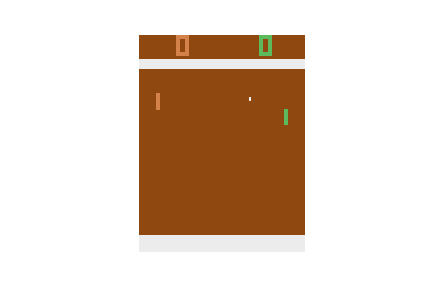
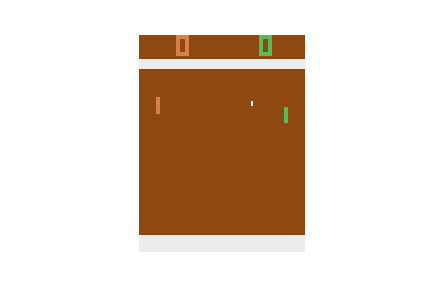
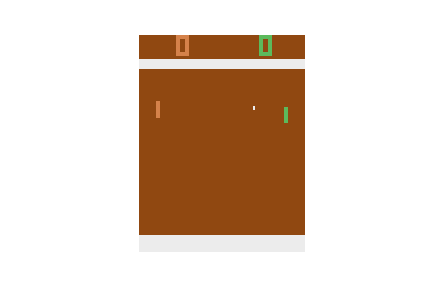
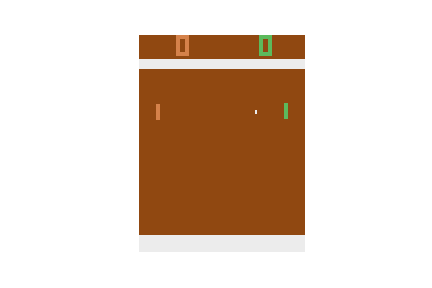
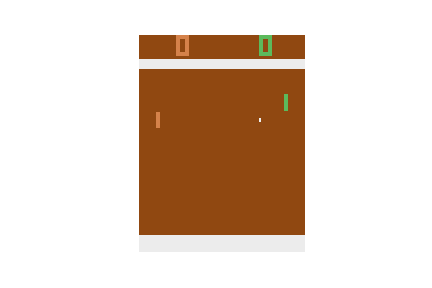
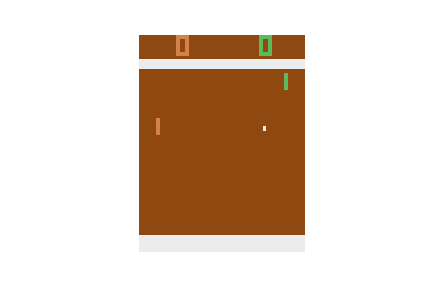
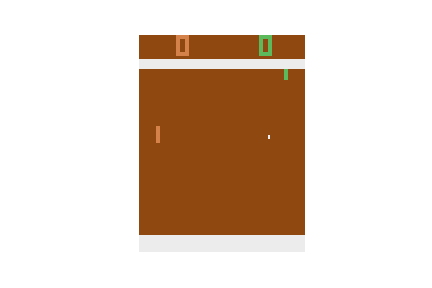
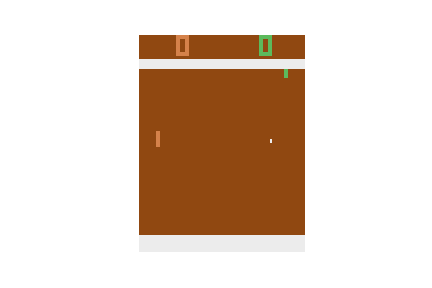
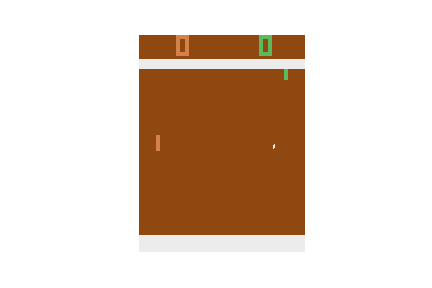
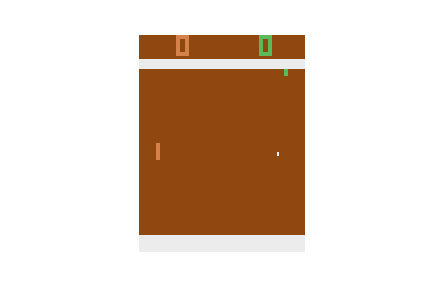
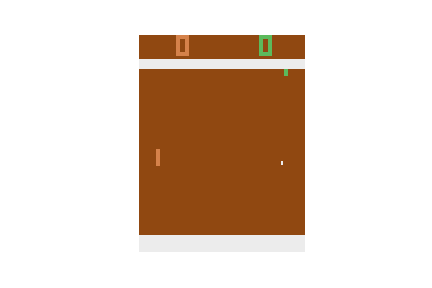
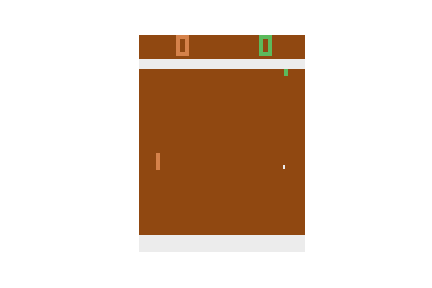
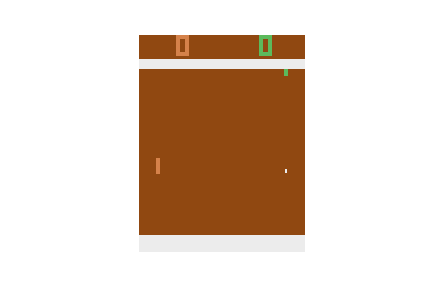
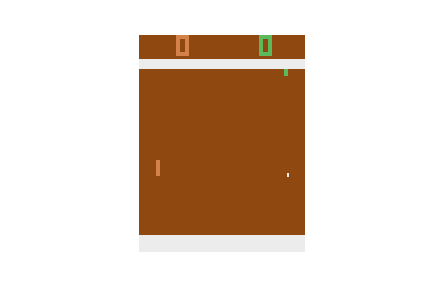
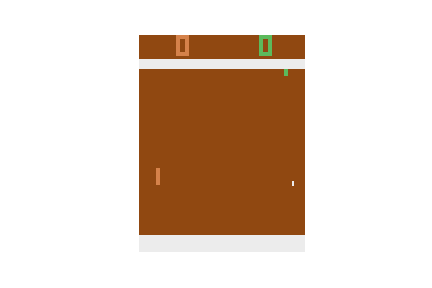
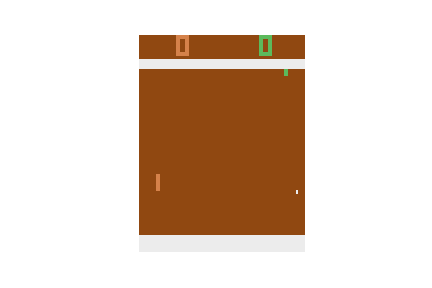
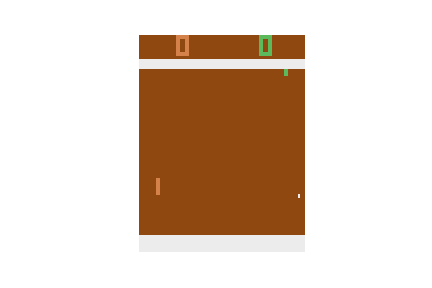
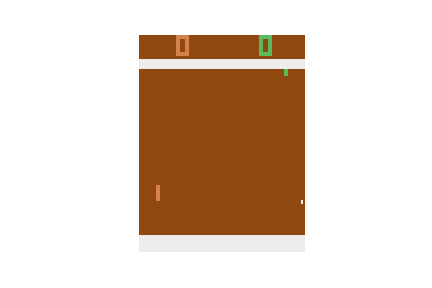
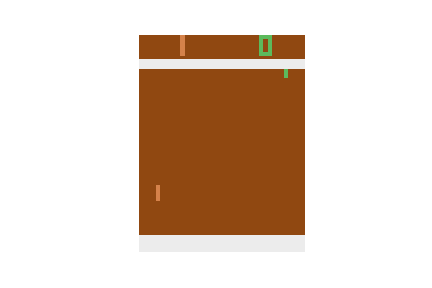
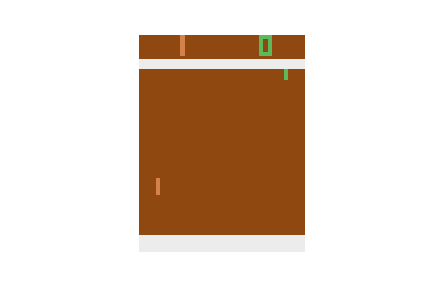
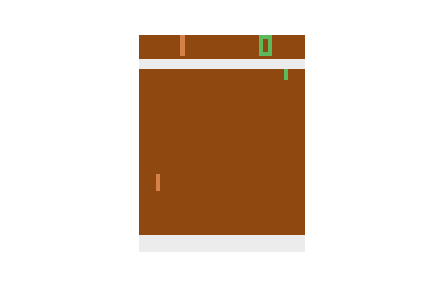
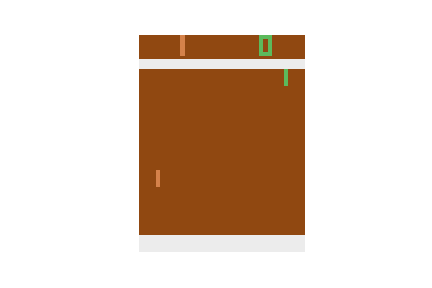
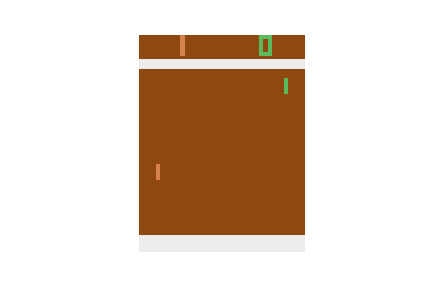
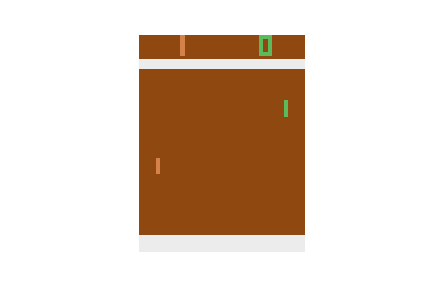
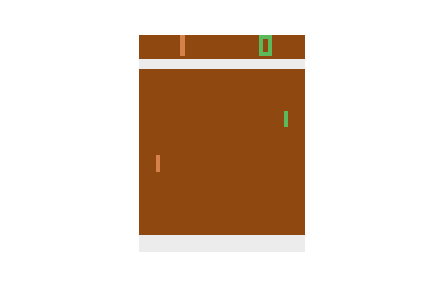
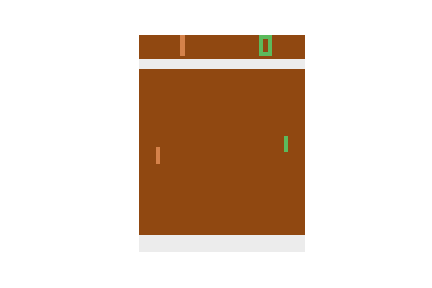
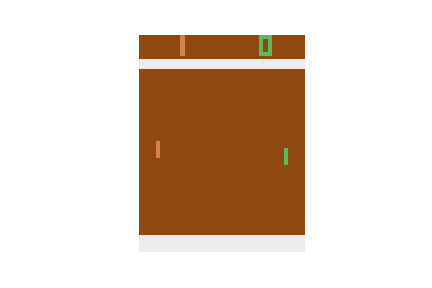
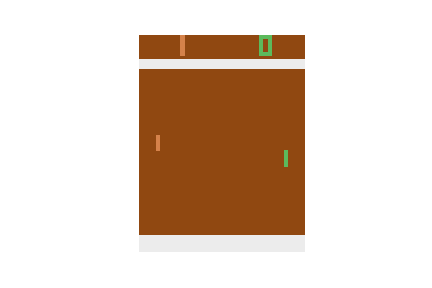
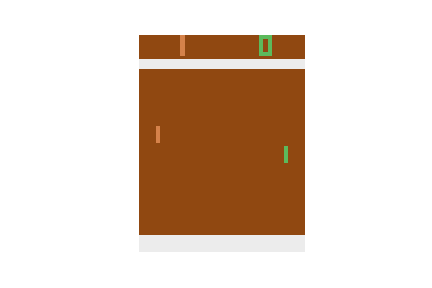
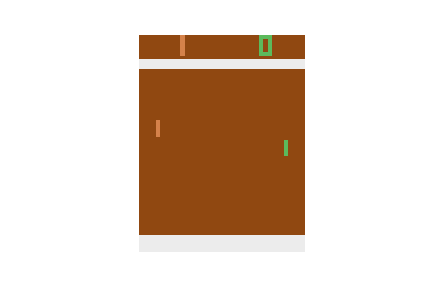

99


In [6]:
observation = env.reset()
cum_reward = 0
frames = []
r = []
for t in range(100):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    p = [0.5, 0.3, 0.2]
    a = np.random.choice(3, p=p)
    action = action_space[a]
    observation, reward, done, info = env.step(action)
    r.append(reward)
    if done:
        break
        
r = np.array(r)
# env.render(close=True)
display_frames_as_gif(frames)
print(t)

In [7]:
gamma = 0.99
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(discounted_r))):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add =  r[t] + running_add * gamma # belman equation
        discounted_r[t] = running_add
    return discounted_r

def discount_n_standardise(r):
    dr = discount_rewards(r)
    dr = (dr - dr.mean()) / dr.std()
    return dr

## Preprocess image

In [8]:
def preprocess(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)[:,:,None]

## Reinforcement Learning

It turns out that action 2 makes the racket go up and 3 makes the racket go down. It has 6 actions by default because it's an Atari game, and there were 6 buttons in the controller. See [here](https://ai.stackexchange.com/questions/2449/what-are-different-actions-in-action-space-of-environment-of-pong-v0-game-from) for source of this answer.

In [9]:
def policy_loss(adv_y_true, y_pred):
    reward = adv_y_true[:,0]
    y_true = adv_y_true[:,1:]
    return K.mean(reward*
                  K.sparse_categorical_crossentropy(y_true, y_pred), 
                  axis=-1)

In [21]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3,3), padding='same', activation='relu', input_shape = (80,80,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(12, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop', loss=policy_loss) #

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 80, 80, 4)         40        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 40, 40, 4)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 40, 40, 8)         296       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 12)        876       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 12)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        1744      
__________

In [ ]:
episodes = 0
n_episodes = 1000
reward_sums = np.zeros(n_episodes)
losses = np.zeros(n_episodes)
time_taken = np.zeros(n_episodes)
reward_sum = 0
prev_x = None
im_shape = (80, 80, 1)

prev_frame = None
buffer = 30000
xs = np.zeros((buffer,)+im_shape)
ys = np.zeros(buffer)
rs = np.zeros(buffer)


k = 0

observation = env.reset()

while episodes<n_episodes:
    x = preprocess(observation)
    xs[k] = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    prev_frame = x
    
    p = model.predict(xs[k][None,:,:,:])
    a = np.random.choice(3, p=p[0])
    action = action_space[a]
    ys[k] = a
    
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    rs[k] = reward
    
    k += 1
    
    if done or k==buffer:
        reward_sums[episodes] = reward_sum
        reward_sum = 0
        
        
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        
        ep_r = discount_n_standardise(ep_r)
        model.fit(ep_x, np.hstack([ep_r, ep_y]), batch_size=512, epochs=1, verbose=0)
        
        time_taken[episodes] = k
        k = 0
        prev_frame = None
        observation = env.reset()
        losses[episodes] = model.evaluate(ep_x, 
                                          np.hstack([ep_r, ep_y]), 
                                          batch_size=len(ep_x), 
                                          verbose=0)
        episodes += 1
        
        if episodes%(n_episodes//20) == 0:
            ave_reward = np.mean(reward_sums[max(0,episodes-200):episodes])
            ave_loss = np.mean(losses[max(0,episodes-200):episodes])
            ave_time = np.mean(time_taken[max(0,episodes-200):episodes])
            print('Episode: {0:d}, Average Loss: {1:.4f}, Average Reward: {2:.4f}, Average steps: {3:.4f}'
                  .format(episodes, ave_loss, ave_reward, ave_time))

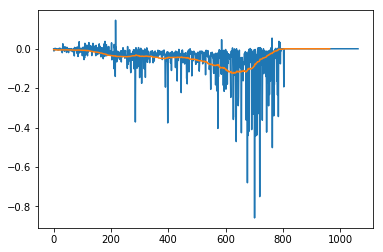

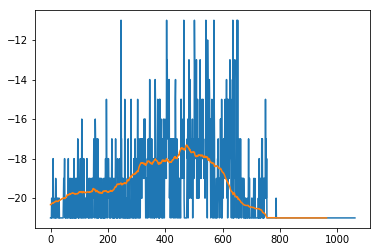

In [17]:
plt.plot(losses[:episodes])
plt.plot(np.convolve(losses[:episodes], np.ones((100,))/100, mode='valid'))
plt.show()

plt.plot(reward_sums[:episodes])
plt.plot(np.convolve(reward_sums[:episodes], np.ones((100,))/100, mode='valid'))
plt.show()

## Result

In [ ]:
observation = env.reset()
cum_reward = 0
frames = []
prev_frame = None
for t in range(5000):
    x = preprocess(observation) 
    diff = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    p = model.predict(diff[None,:,:,:])
    prev_frame = x
    a = np.random.choice(3, p=p[0])
    action = action_space[a]
    
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    observation, reward, done, info = env.step(action)
    if done:
        break
        
# env.render(close=True)
display_frames_as_gif(frames)
print(t)